### CS 484/684 Computational Vision
#### credits: many thanks for the design of this assignemnt go to <a href="https://tovacinni.github.io/" target = "_blank">Towaki Takikawa</a> 

# Homework Assignment #5 - Supervised Deep Learning for Segmentation

This assignment will test your understanding of applying deep learning by having you apply (fully supervised) deep learning to semantic segmentation, a well studied problem in computer vision. 

You can get most of the work done using only CPU, however, the use of GPU will be helpful in later parts. Programming and debugging everything upto and including problem 5c should be fine on CPU. You will notice the benefit of GPU mostly in later parts (d-h) of problem 5, but they are mainly implemenmted and test your code written and debugged earlier. If you do not have a GPU readily accesible to you, we recommend that you use Google Colaboratory to get access to a GPU. Once you are satisfied with your code upto and including 5(c), simply upload this Jupyter Notebook to Google Colaboratory to run the tests in later parts of Problem 5.

Proficiency with PyTorch is required. Working through the PyTorch tutorials will make this assignment significantly easier. https://pytorch.org/tutorials/

In [ ]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
!cp -r "drive/My Drive/a5/images/" .
!cp -r "drive/My Drive/a5/lib/" .

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [462]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries used for HW4.
# Detailed installation instructions are here: https://pytorch.org/get-started/locally/
# That web site should help you to select the right 'conda install' command to be run in 'Anaconda Prompt'.
# In particular, select the right version of CUDA. Note that prior to installing PyTorch, you should  
# install the latest driver for your GPU and CUDA (9.2 or 10.1), assuming your GPU supports it. 
# For more information about pytorch refer to 
# https://pytorch.org/docs/stable/nn.functional.html
# https://pytorch.org/docs/stable/data.html.
# and https://pytorch.org/docs/stable/torchvision/transforms.html
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

# We provide our own implementation of torchvision.datasets.voc (containing popular "Pascal" dataset)
# that allows us to easily create single-image datasets
from lib.voc import VOCSegmentation

# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined

In [ ]:
! pip install chainercv

     |████████████████████████████████| 266kB 7.9MB/s 
  Created wheel for chainercv: filename=chainercv-0.13.1-cp36-cp36m-linux_x86_64.whl size=537354 sha256=34cbc5ea0571b258be8cca2a748feadd4e59d3fc528d8548ee5a013aa108daf5
  Stored in directory: /root/.cache/pip/wheels/ea/10/01/e221beaa4b3d8341aa819a39ab8d4677457c79c81f521f3a94
Successfully built chainercv


In [ ]:
# ChainerCV is a library similar to TorchVision, created and maintained by Preferred Networks. 
# Chainer, the base library, inspired and led to the creation of PyTorch! 
# Although Chainer and PyTorch are different, there are some nice functionalities in ChainerCV 
# that are useful, so we include it as an excersice on learning other libraries.
# To install ChainerCV, normally it suffices to run "pip install chainercv" inside "Anaconda Prompt".
# For more detailed installation instructions, see https://chainercv.readthedocs.io/en/stable/install.html
# For other information about ChainerCV library, refer to https://chainercv.readthedocs.io/en/stable/ 
from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [ ]:
# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

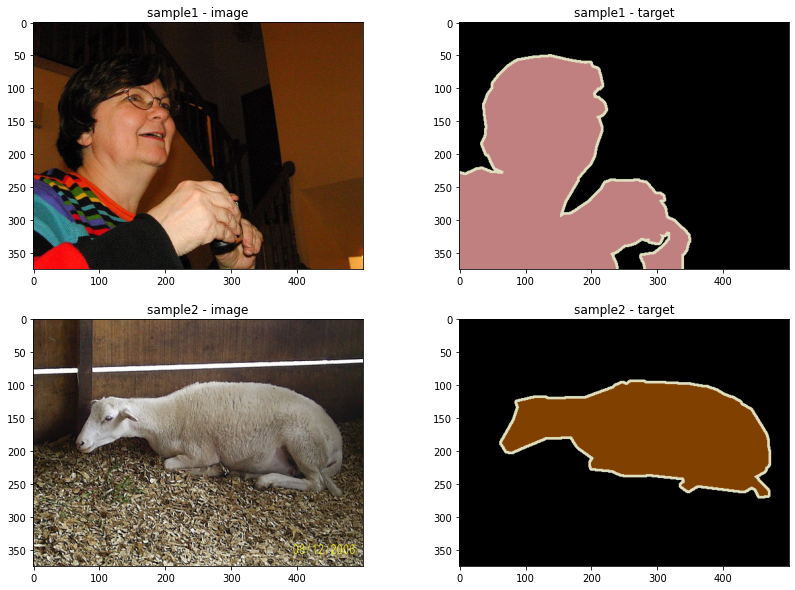

In [ ]:
# Below we will use a sample image-target pair from VOC training dataset to test your joint transforms. 
# Running this block will automatically download the PASCAL VOC Dataset (3.7GB) to DATASET_PATH if "download = True".
# The code below creates subdirectory "datasets" in the same location as the notebook file, but
# you can modify DATASET_PATH to download the dataset to any custom directory. Download takes a few minutes.
# On subsequent runs you may save time by setting "download = False" (the default value of this flag)

DATASET_PATH = 'datasets'  

# Here, we obtain and visualize one sample (img, target) pair from VOC training dataset and one from validation dataset. 
# Note that operator [...] extracts the sample corresponding to the specified index. 
# Also, note the parameter download = True. Set this to False after you download to save time on later runs.
sample1 = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[200]
sample2 = VOCSegmentation(DATASET_PATH, image_set='val')[20]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

# Problem 1 

#### Implement a set of "Joint Transform" functions to perform data augmentation in your dataset. 

Neural networks are typically applied to transformed images. There are several important reasons for this: 

1. The image data should is in certain required format (i.e. consistent spacial resolution to batch). The images should also be normalized and converted to the "tensor" data format expected by pytorch libraries. 

2. Some transforms are used to perform randomized image domain transformations with the purpose of "data augmentation". 

In this exercise, you will implement a set of different transform functions to do both of these things. Note that unlike classification nets, training semantic segmentation networks requires that some of the transforms are applied to both image and the corresponding "target" (Ground Truth segmentation mask). We refer to such transforms and their compositions as "Joint". In general, your Transform classes should take as the input both the image and the target, and return a tuple of the transformed input image and target. Be sure to use critical thinking to determine if you can apply the same transform function to both the input and the output.

For this problem you may use any of the `torchvision.transforms.functional` functions. For inspiration, refer to:
#### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#### https://pytorch.org/docs/stable/torchvision/transforms.html#module-torchvision.transforms.functional

#### Example 1

This class takes a img, target pair, and then transform the pair such that they are in `Torch.Tensor()` format.

#### Solution:

In [ ]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long()

class JointToPil(object):
    def __call__(self, img, target):
      return tF.to_pil_image(img), colorize_mask(target.numpy())

In [ ]:
# Check the transform by passing the image-target sample.

JointToTensor()(*sample1)

(tensor([[[0.0431, 0.0510, 0.0353,  ..., 0.3137, 0.3725, 0.3490],
          [0.0196, 0.0431, 0.0235,  ..., 0.3294, 0.3569, 0.3294],
          [0.0392, 0.0510, 0.0471,  ..., 0.3412, 0.3765, 0.3608],
          ...,
          [0.9412, 0.9961, 1.0000,  ..., 0.9647, 0.9686, 0.9725],
          [1.0000, 0.9686, 0.9961,  ..., 0.9608, 0.9647, 0.9686],
          [1.0000, 0.9490, 1.0000,  ..., 0.9725, 0.9725, 0.9843]],
 
         [[0.0392, 0.0471, 0.0196,  ..., 0.1176, 0.1765, 0.1647],
          [0.0157, 0.0392, 0.0078,  ..., 0.1294, 0.1608, 0.1333],
          [0.0353, 0.0471, 0.0314,  ..., 0.1294, 0.1765, 0.1608],
          ...,
          [0.0157, 0.0667, 0.0706,  ..., 0.6549, 0.6588, 0.6588],
          [0.0784, 0.0431, 0.0667,  ..., 0.6510, 0.6510, 0.6549],
          [0.0745, 0.0235, 0.0784,  ..., 0.6627, 0.6627, 0.6706]],
 
         [[0.0314, 0.0392, 0.0157,  ..., 0.0118, 0.0706, 0.0549],
          [0.0078, 0.0314, 0.0039,  ..., 0.0235, 0.0549, 0.0275],
          [0.0275, 0.0392, 0.0275,  ...,

#### Example 2: 

This class implements CenterCrop that takes an img, target pair, and then apply a crop about the center of the image such that the output resolution is $\mbox{size} \times \mbox{size}$.

#### Solution:

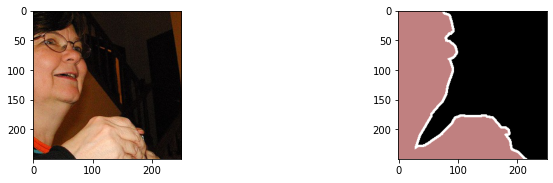

In [ ]:
class JointCenterCrop(object):
    def __init__(self, size):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
            img, target = JointToTensor()(img, target)
        return (tF.five_crop(img, self.size)[4], 
                tF.five_crop(target, self.size)[4])
    
img, target = JointToPil()(*JointCenterCrop(250)(*sample1))

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### (a) Implement RandomFlip

This class should take a img, target pair and then apply a horizontal flip across the vertical axis at random.

#### Solution:

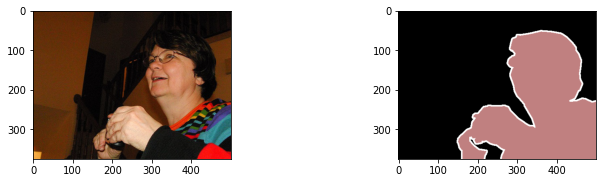

In [ ]:
class JointRandomFlip(object):  
    def __init__(self, p=0.5):
        """
        params:
            p (float) : probability [0,1] of horizontal flip
        """
        self.p = p
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
            img, target = JointToTensor()(img, target)
        return (tF.hflip(img), tF.hflip(target)) if np.random.rand()<self.p else (img, target)
    
img, target = JointToPil()(*JointRandomFlip()(*sample1))

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)


#### (b) Implement RandomResizeCrop

This class should take a img, target pair and then resize the images by a random scale between $[\mbox{minimum_scale}, \mbox{maximum_scale}]$, crop a random location of the image by $\min(\mbox{size}, \mbox{image_height}, \mbox{image_width})$ (where the size is passed in as an integer in the constructor), and then resize to $\mbox{size} \times \mbox{size}$ (again, the size passed in). The crop box should fit within the image.

#### Solution:

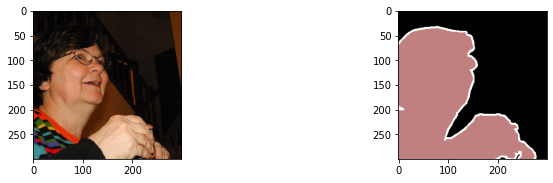

In [ ]:

class JointRandomResizeCrop(object):  
    def __init__(self, scale, size):
        """
        params:
            scale (tuple): (minimum_scale, maximum_scale)
            size (float): size of output image (and potentially crop)
        """
        self.scale = scale
        self.size = size
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
              img, target = JointToTensor()(img, target)
        #concatenate img and target
        t = torch.cat((img,target.reshape(1,*target.shape)))

        # Resize to random size in scale (inclusive of both edge values)
        s = np.random.uniform(*self.scale)
        sz = int(t.shape[1]*s),  int(t.shape[2]*s)
        t = tF.resize(t, sz, interpolation=PIL.Image.NEAREST)

        crop = min(self.size,*t.shape[1:])
        r, c = np.random.uniform(t.shape[1]-crop), np.random.uniform(t.shape[2]-crop)
        # r, c = int(min(r, t.shape[1]-crop)), int(min(c, t.shape[2]-crop))
        r, c = int(r), int(c)
        t = tF.resized_crop(t, top=r, left=c, height=crop, width=crop, size=self.size, interpolation=PIL.Image.NEAREST)

        return t[:3], t[-1]

size=300
scale=(0.8, 1.1) # min and max scaling factor 
img, target = JointToPil()(*JointRandomResizeCrop(scale=scale, size=size)(*sample1))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)


#### (c) Implement Normalize

This class should take a img, target pair and then normalize the images by subtracting the mean and dividing variance. 

#### Solution:

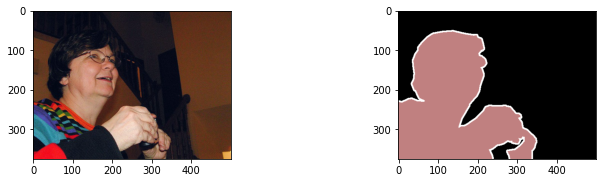

In [ ]:
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])

class JointNormalize(object):  
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
              img, target = JointToTensor()(img, target)
        # img = tF.normalize(img, img.mean(), img.std())

        #Normalize with ImageNet's mean and std. dev
        img = tF.normalize(img, norm[0], norm[1])

        return img, target
        

# img, target = JointToPil()(*JointNormalize()(*sample1))
img, target = JointNormalize()(*sample1)
# Convert to viewable values for plotting/debugging
img1 = (img.permute(1,2,0) + torch.abs(img.min()))/(img.max()+torch.abs(img.min()))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(target.numpy()))

In [ ]:
# This shows that the image was normalized (using ImageNet mean and std_dev)
img.mean(), img1.mean(), JointToTensor()(*sample1)[0].mean()

(tensor(-1.0637), tensor(0.2355), tensor(0.2091))

#### (d) Compose the transforms together: 
##### Use `JointCompose` (fully implemeted below) to compose the implemented transforms together in some random order. Verify the output makes sense and visualize it.


In [447]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. This cell is fully implemented.

class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

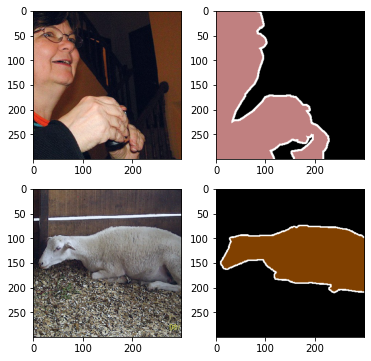

In [459]:
# Student Answer:

size=300
scale=(0.8, 1.1)
tforms = [JointRandomFlip(), JointRandomResizeCrop(scale=scale, size=size), JointNormalize()]




###### PLOT RESULTS ######
img, target = JointCompose(tforms)(*sample1)
# Convert normalized image to viewable values [0,1] for plotting/debugging
img1 = (img.permute(1,2,0) + torch.abs(img.min()))/(img.max()+torch.abs(img.min()))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(target.numpy()))


img, target = JointCompose(tforms)(*sample2)
# Convert normalized image to viewable values [0,1] for plotting/debugging
img1 = (img.permute(1,2,0) + torch.abs(img.min()))/(img.max()+torch.abs(img.min()))

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img1)
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(colorize_mask(target.numpy()))


## Output makes sense

The resulting images are randomly flipped, cropped at random points, and normalized. Note that the normalized images cannot be plotted (as they contain negative values), so the above images are converted to the [0,1] range to be plotted. 


#### (e) Compose the transforms together: use `JointCompose` to compose the implemented transforms for:
#### 1. A sanity dataset that will contain 1 single image. Your objective is to overfit on this 1 image, so choose your transforms and parameters accordingly.
#### 2. A training dataset that will contain the training images. The goal here is to generalize to the validation set, which is unseen.
#### 3. A validation dataset that will contain the validation images. The goal here is to measure the 'true' performance.

In [ ]:
# Student Answer:


size=250 #Get output to be 300
scale=(0.6, 1.4) # +- 40% scaling

#No data augmentation required if goal is to overfit. Just apply normalization
sanity_joint_transform = [JointNormalize()]

train_joint_transform = [JointRandomFlip(), JointRandomResizeCrop(scale=scale, size=size), JointNormalize()]

val_joint_transform =



This code below will then apply `train_joint_transform` to the entire dataset.

In [ ]:
# Apply the Joint-Compose transformations above to create three datasets and the corresponding Data-Loaders.
# This cell is fully implemented.

# This single image data(sub)set can help to better understand and to debug the network training process. 
# Optional integer parameter 'sanity_check' specifies the index of the image-target pair and creates a single image dataset.
# Note that we use the same image (index=200) as used for sample1.
sanity_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = sanity_joint_transform,
    sanity_check = 200
)

# This is a standard VOC data(sub)set used for training semantic segmentation networks
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = train_joint_transform
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = val_joint_transform
)

# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 4

# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS = 0

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

# Problem 2

#### (a) Implement encoder/decoder segmentation CNN using PyTorch.

You must follow the general network architecture specified in the image below. Note that since convolutional layers are the main building blocks in common network architectures for image analysis, the corresponding blocks are typically unlabeled in the network diagrams. The network should have 5 (pre-trained) convolutional layers (residual blocks) from "resnet" in the encoder part, two upsampling layers, and one skip connection. For the layer before the final upsampling layer, lightly experiment with some combination of Conv, ReLU, BatchNorm, and/or other layers to see how it affects performance.   
<img src="images/deeplabv2_overview.png"> 
You should choose specific parameters for all layers, but the overall structure should be restricted to what is shown in the illustration above. For inspiration, you can refer to papers in the citation section of the following link to DeepLab (e.g. specific parameters for each layer): http://liangchiehchen.com/projects/DeepLab.html. The first two papers in the citation section are particularly relevant. 

In your implementation, you can use a base model of choice (you can use `torchvision.models` as a starting point), but we suggest that you learn the properties of each base model and choose one according to the computational resources available to you.

##### Note: do not apply any post-processing (such as DenseCRF) to the output of your net.

#### Solution:


In [477]:
res18 = models.resnet18(pretrained=True)
res18_conv = nn.Sequential(*list(res18.children())[4:9])
res18_conv

Sequential(
  (0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2,

In [463]:
import torchvision.models as models

class MyNet(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(MyNet, self).__init__()
        
    
    def forward(self, inp, gts=None):

        # Implement me
        
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)              
        else:
            # Return the actual prediction otherwise
            return lfinal




#### (b) Create UNTRAINED_NET and run on a sample image

In [ ]:
untrained_net = MyNet(21).eval()
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
untrained_output = untrained_net.forward(sample_img[None])

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,3,1)
plt.title('image sample')
ax.imshow(sample1[0])
ax = fig.add_subplot(1,3,2)
plt.title('ground truth (target)')
ax.imshow(sample1[1])
ax = fig.add_subplot(1,3,3)
plt.title('UNTRAINED_NET output/prediction')
ax.imshow(colorize_mask(torch.argmax(untrained_output, dim=1).numpy()[0]))

# Problem 3 

#### (a) Implement the loss function (Cross Entropy Loss). Do not use already implemented versions of this loss function.

Feel free to use functions like `F.log_softmax` and `F.nll_loss` (if you want to, or you can just implement the math).


In [ ]:
# Student Answer:

# class MyCrossEntropyLoss(...):


#### (b) Compare against the existing CrossEntropyLoss function on your sample output from your neural network.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)

print(criterion(untrained_output, sample_target[None]))

my_criterion = MyCrossEntropyLoss(ignore_index=255)

print(my_criterion(untrained_output, sample_target[None]))
    

# Problem 4

#### (a) Use standard function `eval_semantic_segmentation` (already imported from chainerCV) to compute "mean intersection over union" for the output of UNTRAINED_NET on sample1 (`untrained_output`) using the target for sample1. Read documentations for function  `eval_semantic_segmentation` to properly set its input parameters.

In [ ]:
# Write code to propely compute 'pred' and 'gts' as arguments for function 'eval_semantic_segemntation'

# pred =
# gts =

conf = eval_semantic_segmentation(pred, gts)

print("mIoU for the sample image / ground truth pair: {}".format(conf['miou']))

#### (b) Write the validation loop.

In [ ]:
def validate(val_loader, net):
    
    iou_arr = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
        
            inputs, masks = data

            if USE_GPU:
                # Write me
            else: 
                # Write me
            
            # Write me

            # Hint: make sure the range of values of the ground truth is what you expect

            conf = eval_semantic_segmentation(preds, gts)

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

#### (c) Run the validation loop for UNTRAINED_NET against the sanity validation dataset.

In [ ]:
%%time
print("mIoU over the sanity dataset:{}".format(validate(sanity_loader, untrained_net)[1]))

# Problem 5

#### (a) Define an optimizer to train the given loss function.

Feel free to choose your optimizer of choice from https://pytorch.org/docs/stable/optim.html.


In [ ]:
def get_optimizer(net):
    # Write me
    return optimizer




#### (b) Write the training loop to train the network. 


In [ ]:
def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, masks = data

        if USE_GPU:
            # Write me
        
        # Write me
        
        # loss_graph.append() Populate this list to graph the loss
        
    return main_loss

#### (c) Create OVERFIT_NET and train it on the single image dataset.
##### Single image training is helpful for debugging and hyper-parameter tuning (e.g. learning rate, etc.) as it is fast even on a single CPU. In particular, you can work with a single image until your loss function is consistently decreasing during training loop and the network starts producing a reasonable output for this training image. Training on a single image also teaches about overfitting, particualrly when comparing it with more thorough forms of network training. 

In [ ]:
%%time
%matplotlib notebook

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU). 
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets 
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training. 
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net. 
overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
overfit_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# You can change the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

%matplotlib inline

#### Qualitative and quantitative evaluation of predictions (untrained vs overfit nets) - fully implemented.

In [ ]:
# switch back to evaluation mode
overfit_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for its training image)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

In [ ]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

#### Run the validation loop for OVERFIT_NET against the sanity dataset (an image it was trained on) - fully implemented

In [ ]:
%%time
print("mIoU for OVERFIT_NET over its training image:{}".format(validate(sanity_loader, overfit_net)[1]))

### WARNING: For the remaining part of the assignment (below) it is advisable to switch to GPU mode as running each validation and training loop on the whole training set takes over an hour on CPU (there are several such loops below). Note that GPU mode is helpful only if you have a sufficiently good NVIDIA gpu (not older than 2-3 years) and cuda installed on your computer. If you do not have a sufficiently good graphics card available, you can still finish the remaining part in CPU mode (takes a few hours), as the cells below are mostly implemented and test your code written and debugged in the earlier parts above. You can also switch to Google Colaboratory to run the remaining parts below.

### You can use validation-data experiments below to tune your hyper-parameters. Normally, validation data is used exactly for this purpose. For actual competitions, testing data is not public and you can not tune hyper-parameters on in. 

#### (d) Evaluate UNTRAINED_NET and OVERFIT_NET on validation dataset.
##### Run the validation loop for UNTRAINED_NET against the validation dataset:

In [ ]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)[1]))

##### Run the validation loop for OVERFIT_NET against the validation dataset (it has not seen): 

In [ ]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for OVERFIT_NET over the validation dataset:{}".format(validate(val_loader, overfit_net)[1]))

#### (e) Explain in a few sentences the quantitative results observed in (c) and (d):

Student answer:

#### (f) Create TRAINED_NET and train it on the full training dataset:

In [ ]:
%%time
%matplotlib notebook

# This training will be very slow on a CPU (>1hour per epoch). Ideally, this should be run in GPU mode (USE_GPU=True) 
# taking only a few minutes per epoch (depending on your GPU and batch size). Thus, before proceeding with this excercise,
# it is highly advisable that you first finish debugging your net code. In particular, make sure that OVERFIT_NET behaves 
# reasonably, e.g. its loss monotonically decreases during training and its output is OK (for the image it was trained on). 
# Below we create another (deep) copy of untrained_net. Unlike OVERFIT_NET it will be trained on a full training dataset.
trained_net = copy.deepcopy(untrained_net)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=255)


# You can change the number of EPOCHS below. Since each epoch for TRAINED_NET iterates over all training dataset images,
# the number of required epochs could be smaller compared to OFERFIT_NET where each epoch iterates over one-image-dataset)
EPOCH = 2

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAINED_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()    
    print("Epoch: {} Loss: {}".format(e, loss))
    
%matplotlib inline

#### (g) Qualitative and quantitative evaluation of predictions (OVERFIT_NET vs TRAINED_NET):

In [ ]:
# switch back to evaluation mode
trained_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for its training image)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for one of its training images)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

In [ ]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

#### (h) Evaluate TRAINED_NET on validation dataset.
##### Run the validation loop for TRAINED_NET against the validation dataset (it has not seen): 

In [ ]:
%%time
# This will be slow on CPU (around 1 hour). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for TRAINED_NET over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

# Problem 6

#### For the network that you implemented, write a paragraph or two about limitations / bottlenecks about the work. What could be improved? What seems to be some obvious issues with the existing works?